In [1]:
# Imports
import cv2
import glob
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Helpers
def plot_before_after(before, after, before_title='Before', after_title='After', gray1=False, gray2=False):
    f, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(14,10))
    ax_l.axis('off')
    ax_l.set_title(before_title, fontsize=20)
    if (gray1):
        ax_l.imshow(before, cmap='gray')
    else:
        ax_l.imshow(before)
        
    ax_r.axis('off')
    ax_r.set_title(after_title, fontsize=20)
    if (gray2):
        ax_r.imshow(after, cmap='gray')
    else:
        ax_r.imshow(after)
    plt.show()

def plot_one(img, title='Title', gray=False):
    f, ax = plt.subplots(1, 1, figsize=(14,10))
    ax.axis('off')
    ax.set_title(title, fontsize=20)
    if (gray):
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    plt.show()


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    cp = np.copy(img)
    for line in lines:
        cv2.line(cp, (line[0], line[1]), (line[2], line[3]), color, thickness)
    return cp

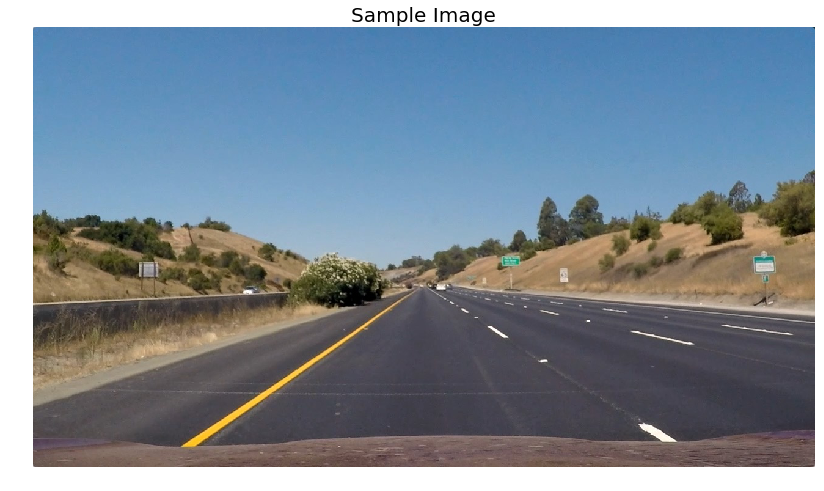

In [3]:
# Load a straight lane image
sample = cv2.imread('./test_images/straight_lines1.jpg')
sample_rgb = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
h, w = sample.shape[:2]

plot_one(sample_rgb, 'Sample Image')

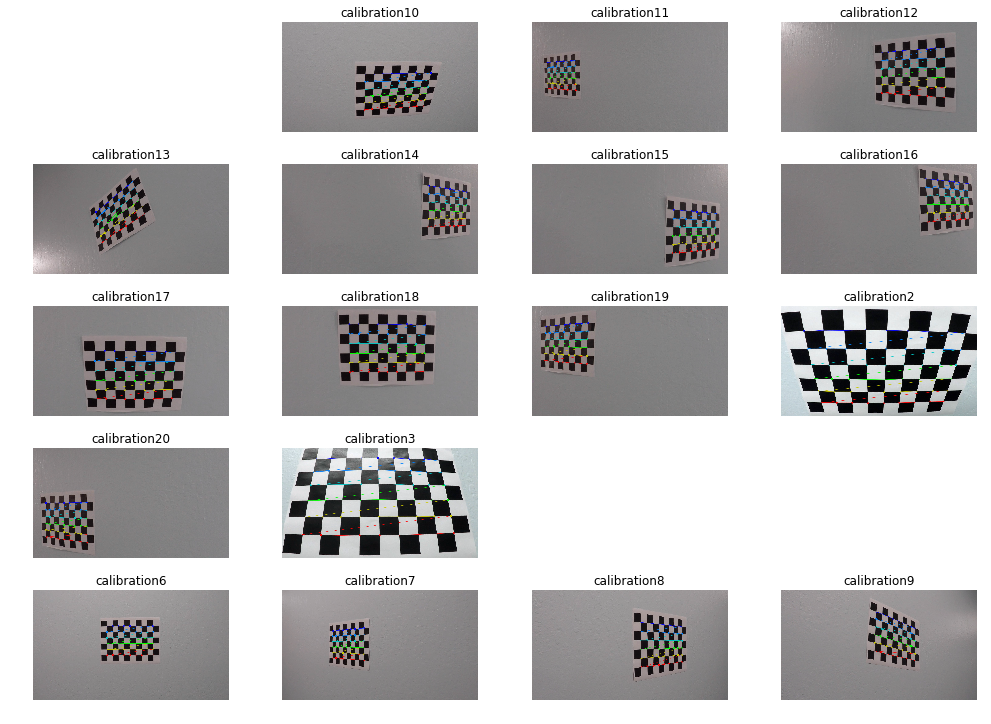

In [4]:
# Inside Corners X/Y
nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Store Calibration Points
objpoints = [] # 3d
imgpoints = [] # 2d

# Calibration Images
images = glob.glob('./camera_cal/calibration*.jpg')
num_images = len(images)
plot_cols = int(np.ceil(num_images / 5))
plot_rows = int(np.ceil(num_images / plot_cols))

# Set up plotting of calibration images
fig, axes = plt.subplots(nrows=plot_rows, ncols=plot_cols, figsize=(14, 10))
axes = axes.ravel()
fig.tight_layout()

# Iterate images
for index, fname in enumerate(images):
    img = cv2.imread(fname)
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    ax = axes[index]
    ax.axis('off')
    if ret == True:
        # Found corners
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        ax.set_title(fname.split('/')[-1].split('.')[0], fontsize=12)
        ax.imshow(img)
    else:
        fig.delaxes(ax)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show()

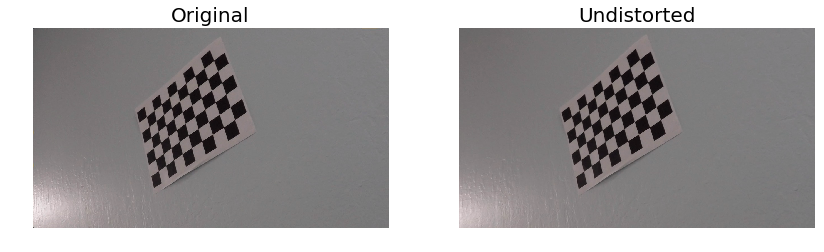

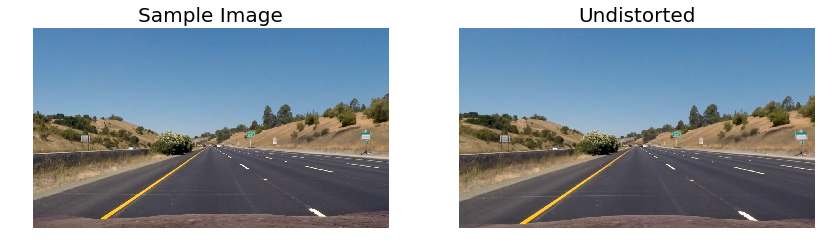

In [5]:
# Get a random image for control
img = cv2.imread(images[random.randint(0, num_images - 1)])
img_size = (img.shape[1], img.shape[0])

# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera matrix and the distortion coefficients
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_calibration.p", "wb"))

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Undistort image
undistorted = undistort(img)
# Undistort sample 
sample_undistorted = undistort(sample_rgb)

# Plot undistortion result for control
plot_before_after(img, undistorted, 'Original', 'Undistorted')
# Plot undistorted sample
plot_before_after(sample_rgb, sample_undistorted, 'Sample Image', 'Undistorted')

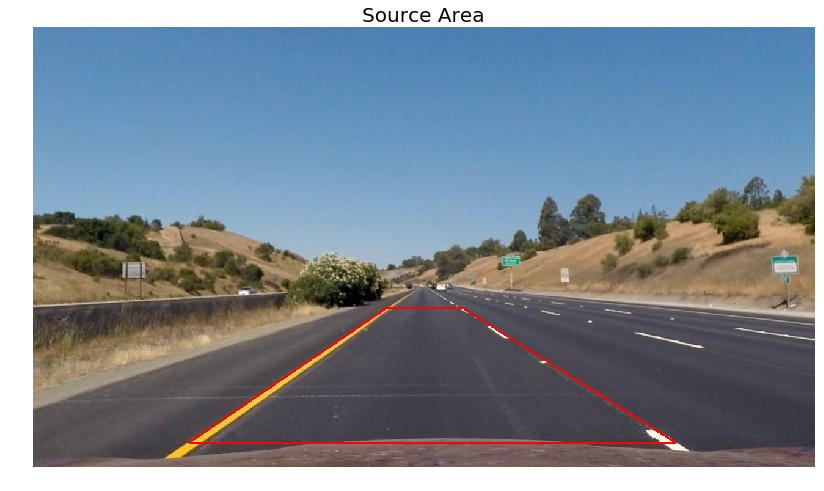

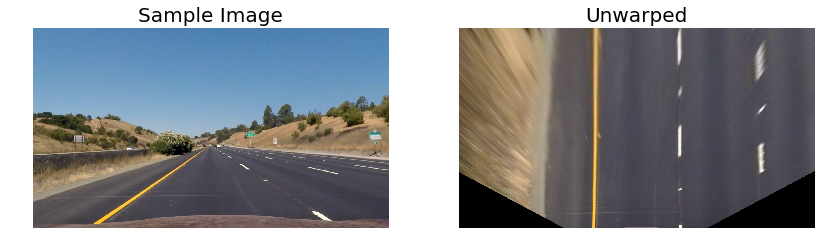

In [6]:
def unwarp(img, src, dst):
    h, w = img.shape[:2]
    # Get the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # Get the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

# Define source & destination for unwrapping
src = np.float32([  (255, 680),
                    (577, 460),
                    (704, 460),
                    (1052, 680)])
width = 480
dst = np.float32([(width, h),
                  (width, 0),
                  (w - width, 0),
                  (w - width, h)])
# Lines for visualization
lines = [np.append(src[0], src[1]), np.append(src[1], src[2]), np.append(src[2], src[3]), np.append(src[3], src[0])]
source_area = draw_lines(sample_undistorted, lines)

# Unwarp image
sample_unwarped, M, Minv  = unwarp(sample_undistorted, src, dst)

# Plot visualization of the source area
plot_one(source_area, 'Source Area')
# Plot unwarped sample image
plot_before_after(sample_undistorted, sample_unwarped, 'Sample Image', 'Unwarped')

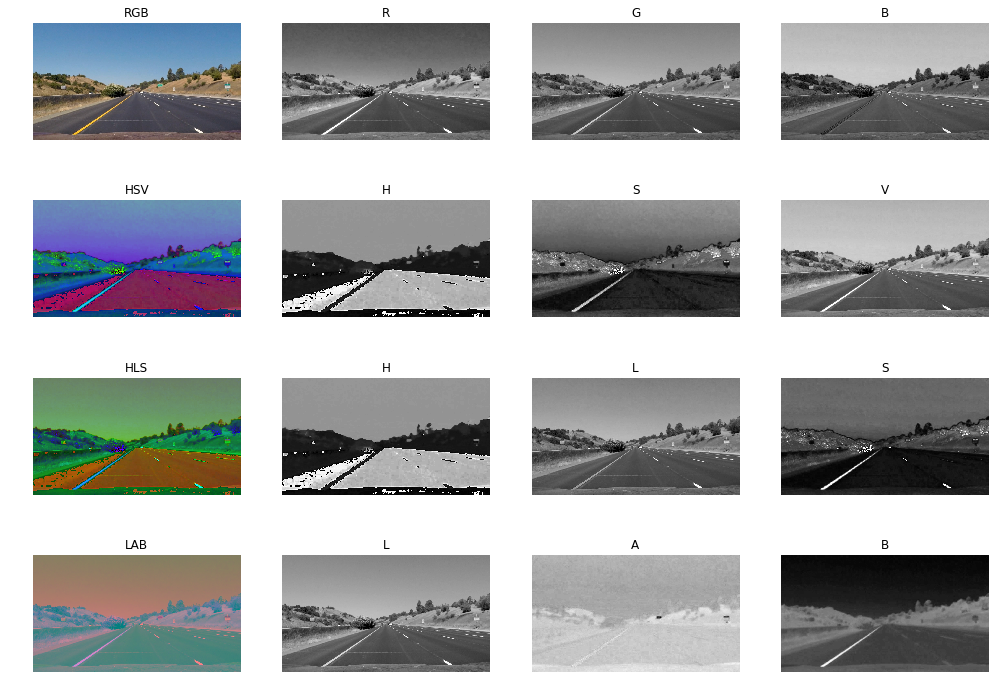

In [7]:
# RBB
sample_rgb = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
sample_r = sample_rgb[:,:,0]
sample_g = sample_rgb[:,:,1]
sample_b = sample_rgb[:,:,2]
# HSV
sample_hsv = cv2.cvtColor(sample_rgb, cv2.COLOR_RGB2HSV)
sample_h = sample_hsv[:,:,0]
sample_s = sample_hsv[:,:,1]
sample_v = sample_hsv[:,:,2]
# HLS
sample_hsl = cv2.cvtColor(sample_rgb, cv2.COLOR_RGB2HLS)
sample_hsl_h = sample_hsl[:,:,0]
sample_hsl_l = sample_hsl[:,:,1]
sample_hsl_s = sample_hsl[:,:,2]
# LAB
sample_lab = cv2.cvtColor(sample_rgb, cv2.COLOR_RGB2Lab)
sample_lab_l = sample_lab[:,:,0]
sample_lab_a = sample_lab[:,:,1]
sample_lab_b = sample_lab[:,:,2]

color_samples = [sample_rgb, sample_r, sample_g, sample_b,
          sample_hsv, sample_h, sample_s, sample_v,
          sample_hsl, sample_hsl_h, sample_hsl_l, sample_hsl_s,
          sample_lab, sample_lab_l, sample_lab_a, sample_lab_b]
color_names = ['RGB', 'R', 'G', 'B',
               'HSV', 'H', 'S', 'V',
               'HLS', 'H', 'L', 'S',
               'LAB', 'L', 'A', 'B']

fig, axes = plt.subplots(4, 4, figsize=(14, 10))
axes = axes.ravel()
fig.tight_layout()

for index, image in enumerate(color_samples):
    ax = axes[index]
    ax.axis('off')
    ax.imshow(color_samples[index], cmap='gray')
    ax.set_title(color_names[index], fontsize=12)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show()

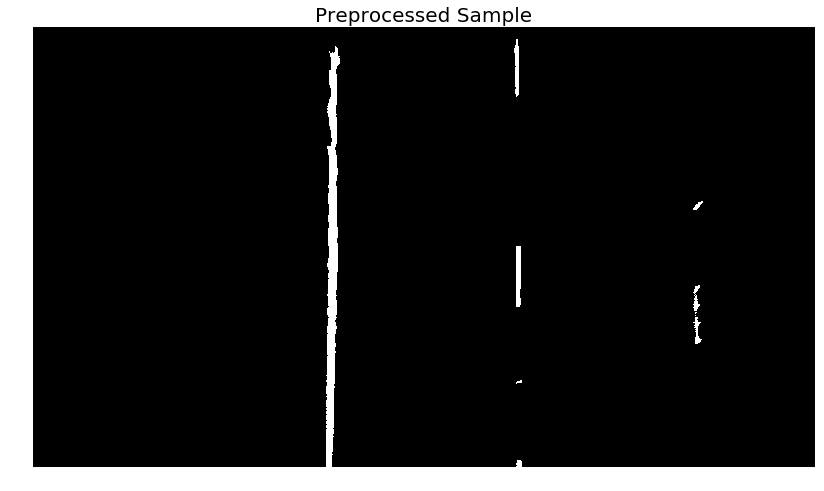

In [8]:
# Convert to HLS, separate L and apply threshold
def hls_l_threshold(img, threshold=(220, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l * (255 / np.max(hls_l)) # normalize
    binary = np.zeros_like(hls_l)
    binary[(hls_l > threshold[0]) & (hls_l <= threshold[1])] = 1
    return binary

def lab_b_threshold(img, threshold=(200, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    if np.max(lab_b) > 175: # normalize when yellow found in image
        lab_b = lab_b * (255 / np.max(lab_b))
    binary = np.zeros_like(lab_b)
    binary[((lab_b > threshold[0]) & (lab_b <= threshold[1]))] = 1
    return binary



# The preprocessing pipeline
def preprocess_image(img):
    img_undistorted = undistort(img)
    img_unwarped, M, Minv = unwarp(img_undistorted, src, dst)
    img_lab_b = lab_b_threshold(img_unwarped)
    img_hls_l = hls_l_threshold(img_unwarped)
    # OR
    img_thersholded = np.zeros_like(img_lab_b)
    img_thersholded[(img_lab_b == 1) | (img_hls_l == 1)] = 1
    return img_thersholded, M, Minv

sample_preprocessed, M, Minv = preprocess_image(sample_rgb)
plot_one(sample_preprocessed, 'Preprocessed Sample', True)

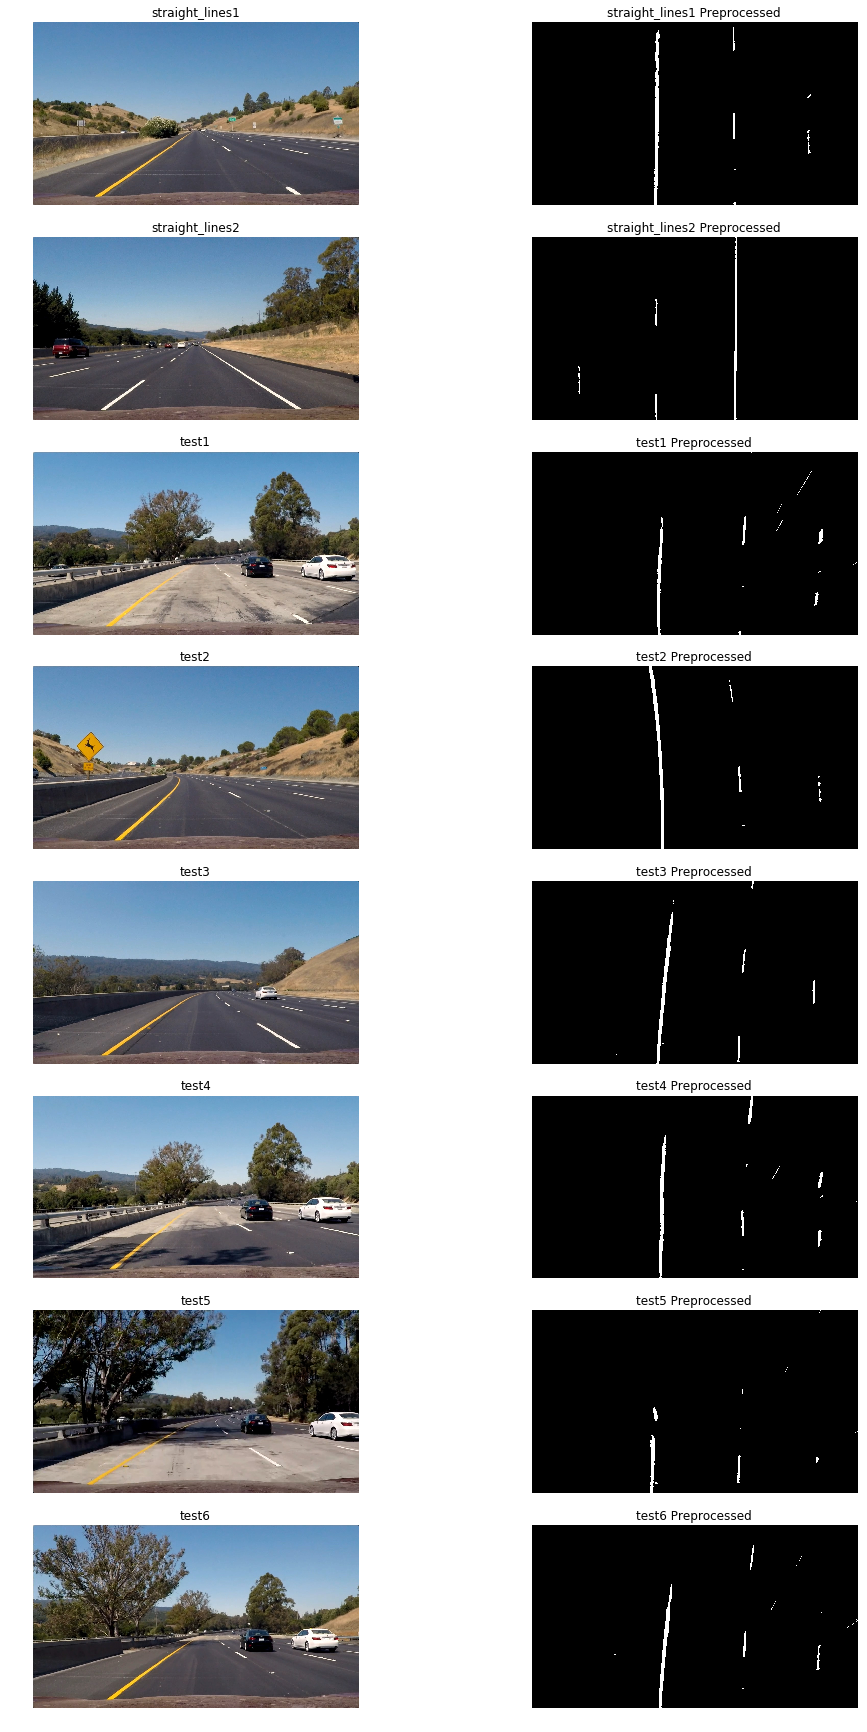

In [9]:
# Sample images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(14, 24))
axes = axes.ravel()
fig.tight_layout()
                  
for index, image in enumerate(images):
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    binary, M, Minv = preprocess_image(img_rgb)
    ax = axes[index * 2]
    ax.axis('off')
    ax.set_title(image.split('/')[-1].split('.')[0], fontsize=12)
    ax.imshow(img_rgb)
    ax = axes[index * 2 + 1]
    ax.axis('off')
    ax.set_title(image.split('/')[-1].split('.')[0] + ' Preprocessed', fontsize=12)
    ax.imshow(binary, cmap='gray')
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show()

In [10]:
def sliding_window_search(img):
    h, w = sample.shape[:2]
    histogram = np.sum(img[h // 2:,:], axis=0)
    half = histogram.shape[0] // 2
    quater = half // 2
    leftx_base = np.argmax(histogram[quater:half]) + quater
    rightx_base = np.argmax(histogram[half:(half + quater)]) + half
    # Window config
    num_windows = 10
    window_height = np.int(img.shape[0] / num_windows)
    margin = 80
    minpix = 40
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    window_data = []

    for window in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        window_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions for polyfit
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    meta_data = (window_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, meta_data


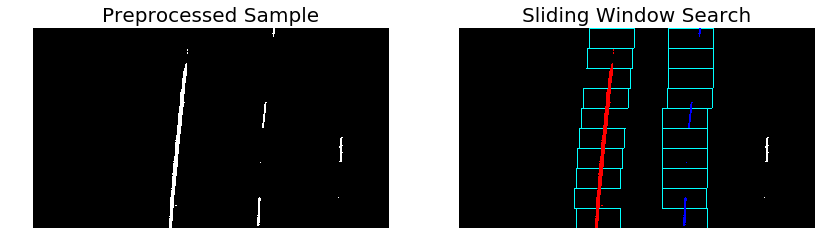

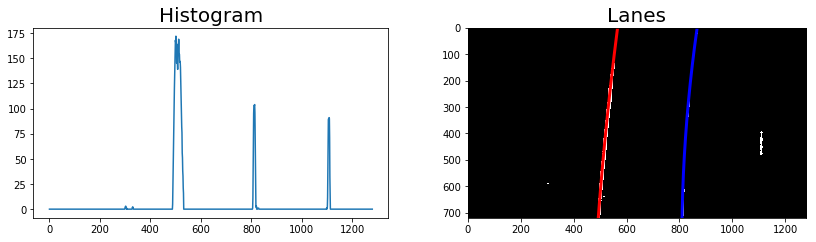

In [11]:
# Load new sample with curvature
sample = cv2.imread('./test_images/test3.jpg')
h, w = sample.shape[:2]
sample_rgb = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
sample_processed, M, Minv = preprocess_image(sample_rgb)

# Sliding window search
left_fit, right_fit, left_lane_inds, right_lane_inds, meta_data = sliding_window_search(sample_processed)

# Extract meta data
windows = meta_data[0]
histogram = meta_data[1]

# Create output for visualization
output = np.uint8(np.dstack((sample_processed, sample_processed, sample_processed)) * 255)

line_samples = np.linspace(0, sample_processed.shape[0] - 1, sample_processed.shape[0])
left_lane = left_fit[0] * line_samples ** 2 + left_fit[1] * line_samples + left_fit[2]
right_lane = right_fit[0] * line_samples ** 2 + right_fit[1] * line_samples + right_fit[2]

for win in windows:
    cv2.rectangle(output, (win[2], win[0]), (win[3], win[1]), (0, 255, 255), 2) 
    cv2.rectangle(output, (win[4], win[0]), (win[5], win[1]), (0, 255, 255), 2) 
    
nonzero = sample_processed.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
output[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
output[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plot_before_after(sample_processed, output, 'Preprocessed Sample', 'Sliding Window Search', True)

f, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(14, 3.5))
ax_l.set_title('Histogram', fontsize=20)
ax_l.plot(histogram)
ax_r.set_title('Lanes', fontsize=20)
ax_r.imshow(sample_processed, cmap='gray')
ax_r.plot(left_lane, line_samples, color='red', linewidth=3)
ax_r.plot(right_lane, line_samples, color='blue', linewidth=3)

In [12]:
def polyfit_using_prev_fit(img, left_fit_prev, right_fit_prev):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    
    left_lane_inds = ((nonzerox > (left_fit_prev[0] * (nonzeroy ** 2) + left_fit_prev[1] * nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0] * (nonzeroy ** 2) + left_fit_prev[1] * nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0] * (nonzeroy ** 2) + right_fit_prev[1] * nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0] * (nonzeroy ** 2) + right_fit_prev[1] * nonzeroy + right_fit_prev[2] + margin)))  
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [13]:
def calc_radius_for_poly(poly, y):
    return ((1 + (2 * poly[0] * y + poly[1]) ** 2) ** 1.5) / np.absolute(2 * poly[0])

def get_radius_and_offset(img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Pixel to meter conversion
    # Meters per pixel, 10 ft lane line (3.048m)
    ym_per_pix = 3.048 / 100
    # Meters per pixel, 12 ft lane (3.7m)
    xm_per_pix = 3.7 / 378
    # Output
    left_radius, right_radius, offset_center = (0, 0, 0)
    
    h,w = img.shape
    samples = np.linspace(0, h - 1, h)
    y_eval = np.max(samples)
  
    # Nonzero pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Left and right line pixels
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) > 0 and len(rightx) > 0:
        # Fit new polynomials (worldpsace)
        left_fit_coefs = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_coefs = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
        # Calculate that radius (worldpsace)
        left_radius = calc_radius_for_poly(left_fit_coefs, y_eval * ym_per_pix)
        right_radius = calc_radius_for_poly(right_fit_coefs, y_eval * ym_per_pix)
    
    # Offset from center
    if r_fit is not None and l_fit is not None:
        cam_pos = w / 2
        l_fit_x_int = l_fit[0] * h ** 2 + l_fit[1] * h + l_fit[2]
        r_fit_x_int = r_fit[0] * h ** 2 + r_fit[1] * h + r_fit[2]
        lane_center = (r_fit_x_int + l_fit_x_int) / 2
        offset_center = (cam_pos - lane_center) * xm_per_pix
    return left_radius, right_radius, offset_center


left_radius, right_radius, offset_center = get_radius_and_offset(sample_processed, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Curvature:', left_radius, 'm,', right_radius, 'm')
print('Offset center:', offset_center, 'm')

Curvature: 1260.12313138 m, 539.913995101 m
Offset center: -0.112758097317 m


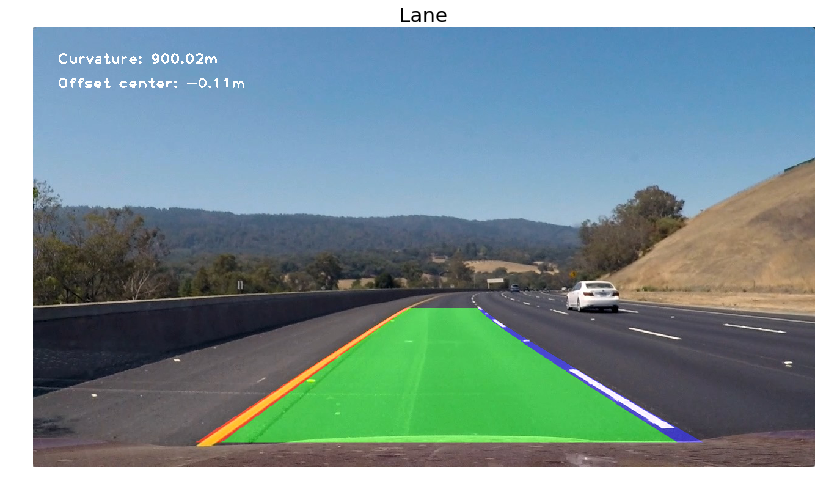

In [14]:
def draw_lanes(original_img, binary_img, l_fit, r_fit, Minv):
    # Early return when no lines
    if l_fit is None or r_fit is None:
        return original_img
    
    new_img = np.copy(original_img)
    # Opaque content goes here
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h, w = binary_img.shape
    ploty = np.linspace(0, h - 1, num=h)
    
    left_fitx = l_fit[0] * ploty ** 2 + l_fit[1] * ploty + l_fit[2]
    right_fitx = r_fit[0] * ploty ** 2 + r_fit[1] * ploty + r_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255, 0, 0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0, 0, 255), thickness=15)

    # Inverse warping
    inverse_warp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Blend images
    result = cv2.addWeighted(new_img, 1, inverse_warp, 0.5, 0)
    return result

def draw_info(original_img, radius, distance):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_PLAIN
    text = 'Curvature: ' + '{:04.2f}'.format(radius) + 'm'
    cv2.putText(new_img, text, (40, 60), font, 1.6, (255, 255, 255), 2)
    text = 'Offset center: {:03.2f}'.format(distance) + 'm'
    cv2.putText(new_img, text, (40, 100), font, 1.6, (255, 255, 255), 2)
    return new_img

sample_lanes = draw_lanes(sample_rgb, sample_preprocessed, left_fit, right_fit, Minv)
sample_info = draw_info(sample_lanes, (left_radius + right_radius) * 0.5, offset_center)
plot_one(sample_info, 'Lane')


In [15]:
class Line:
    def __init__(self):
        self.detected = False  
        self.current_fit = []
        self.average_fit = None
        self.drop_rate = 7
    def is_good_fit(self, fit):
        if self.average_fit is not None:
            diffs = abs(fit - self.average_fit)
            if (diffs[0] > 0.001 or diffs[1] > 1.0 or diffs[2] > 100.0):
                return False
        return True
    def append_fit(self, fit):
        self.current_fit.append(fit)
        if len(self.current_fit) > self.drop_rate:
            self.current_fit = self.current_fit[len(self.current_fit) - self.drop_rate:]
        self.average_fit = np.average(self.current_fit, axis=0)
        self.detected = True
            
    def drop_one(self):
        if len(self.current_fit) > 0:
            self.current_fit = self.current_fit[:len(self.current_fit) - 1]
            if len(self.current_fit) > 0:
                self.average_fit = np.average(self.current_fit, axis=0)
                self.detected = True
            else:
                self.average_fit = None
                self.detected = False
                
    def add(self, fit, inds):
        if fit is None:
            self.drop_one()
        else:
            if not self.is_good_fit(fit):
                self.drop_one()
            else:
                self.append_fit(fit)

In [16]:
def process_img(img):
    preprocessed_img, M, Minv = preprocess_image(img)
    if left_line.detected and right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_using_prev_fit(preprocessed_img, left_line.average_fit, right_line.average_fit)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds, meta_data= sliding_window_search(preprocessed_img)
            
    left_line.add(left_fit, left_lane_inds)
    right_line.add(right_fit, right_lane_inds)

    if left_line.average_fit is not None and left_line.average_fit is not None:
        lane_img = draw_lanes(img, preprocessed_img, left_line.average_fit, right_line.average_fit, Minv)
        left_radius, right_radius, offset_center = get_radius_and_offset(preprocessed_img, left_line.average_fit, right_line.average_fit, left_lane_inds, right_lane_inds)
        output = draw_info(lane_img, (left_radius + right_radius) * .5, offset_center)
    else:
        output = img
        
    return output

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_line = Line()
right_line = Line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_img)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:58<00:00, 10.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 4s, sys: 17.6 s, total: 3min 21s
Wall time: 1min 59s


In [18]:
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')
processed_video = video_input2.fl_image(process_img)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [00:40<00:00, 12.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 3s, sys: 5.95 s, total: 1min 9s
Wall time: 40.8 s


In [19]:
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')
processed_video = video_input3.fl_image(process_img)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:06<00:00,  8.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 2min 58s, sys: 22.8 s, total: 3min 21s
Wall time: 2min 7s
